# Objective
GDP data is released every three month. Is it possible to forecast the next GDP dta release by using the data available before then?

Many types of econoic data are released monthly, and weekly. Using these publically available sources, this notebook will forecast the upcoming GDP release.

# Imports

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis

import sys
from pathlib import Path

sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY

working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [2]:
!pip install -U tqdm requests_cache pandas-datareader hcrystalball pmdarima tbats quandl

Requirement already up-to-date: tqdm in /usr/local/lib/python3.7/dist-packages (4.61.0)
Requirement already up-to-date: requests_cache in /usr/local/lib/python3.7/dist-packages (0.6.3)
Requirement already up-to-date: pandas-datareader in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: hcrystalball in /usr/local/lib/python3.7/dist-packages (0.1.10)
Requirement already up-to-date: pmdarima in /usr/local/lib/python3.7/dist-packages (1.8.2)
Requirement already up-to-date: tbats in /usr/local/lib/python3.7/dist-packages (1.1.0)
Requirement already up-to-date: quandl in /usr/local/lib/python3.7/dist-packages (3.6.1)


In [3]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hcrystalball

In [41]:
endogenous_drivers_by_source = {
    'fred': [
             # Money Supply
             'WM2NS', # M2 Money Stock, weekly, not seasonally adjusted

             # Interest Rates, 
             'FEDFUNDS', # IR% : Effective Federal Funds Rate, monthly

             # Inflation: Consumer and Business Inflation 
             'CPIAUCSL', # CPI: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
             'CPILFESL', # CPI Core: Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average
             'WPSFD49207', # PPI: Producer Price Index by Commodity: Final Demand: Finished Goods, Monthly
             'WPSFD4131', # PPI Core: Producer Price Index by Commodity: Final Demand: Finished Goods Less Foods and Energy, Monthly

             # Employment
             # Employemnt Situation Report: http://data.bls.gov/pdq/SurveyOutputServlet?request_action=wh&graph_name=CE_cesbref1 
             'PAYEMS', # All Employees, Total Nonfarm

             # Balance Sheets and Sovereign Risk
             'GFDEGDQ188S', # Federal Debt: Total Public Debt as Percent of GDP, Seasonally Adjusted
             'FYFSDFYGDP', # Federal Surplus or Deficit [-] as Percent of GDP
             'FYOIGDA188S', # Federal Outlays: Interest as Percent of GDP
             'W018RC1Q027SBEA', # Federal government total receipts, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
             'W019RCQ027SBEA', # Federal government total expenditures, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly,
             'A091RC1Q027SBEA', # Federal government current expenditures: Interest payments, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
             'WGS10YR', # 10-Year Treasury Constant Maturity Rate
             'WALCL', #  CB Balance Sheet: Assets: Total Assets: Total Assets (Less Eliminations from Consolidation): Wednesday Level, Units: Millions of U.S. Dollars, Not Seasonally Adjusted
             #Target 
             'GDPC1', # target:  Real Gross Domestic Product, chained 2012 dollars
             'GDP', # Gross Domestic Product (GDP), Units: Billions of Dollars, Seasonally Adjusted Annual Rate
             'A191RP1Q027SBEA', # GDP Growth, Percent Change from Preceding Period, Seasonally Adjusted Annual Rate

             # Consumer Sentiment
             'UMCSENT',  # Michigan sentiment starting in 1978

             # Building Permits
             'PERMIT', # New housing construction building  permits issued, monthly, seasonally adjusted annualized rate.

             # plotting helper
             'USRECD', # NBER Recession indicator
    ]}
                      


In [42]:
import pandas_datareader
import datetime
import requests_cache

expire_after = datetime.timedelta(days=7)
session = requests_cache.CachedSession(cache_name='us_econ_analysis', expire_after=expire_after)
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.today()

series_id_list = endogenous_drivers_by_source['fred']
params = {
    'api_key': API_KEY['fred'],
    'limit': 100000,
                }
df = pandas_datareader.fred.FredReader(series_id_list, 
                                       start, end, 
                                       session=session).read()

df.index = df.index.rename('date')

# Rename weekly and monthly data series with descriptive names
weekly_data_series = {'WM2NS': 'M2'}
monthly_data_series = {'FEDFUNDS': 'IR',
                       'CPIAUCSL': 'CPI',
                       'CPILFESL': 'CPI_Core',
                       'WPSFD49207': 'PPI',
                       'WPSFD4131': 'PPI_Core',
                       'PAYEMS': 'Employment',
                       'PERMIT': 'building_permits'
                      }

# Calculate changes in weekly and monthly data, then drop raw data
for series_id, new_name in weekly_data_series.items():
  for periods in [1, 2, 3, 4, 12]:
    df[f'{new_name}_{periods}W_pct_change'] = df[series_id].dropna().pct_change(periods=periods) * 100
  df = df.drop(columns=[series_id])

for series_id, new_name in monthly_data_series.items():
  for periods in [1, 2, 3]:
    df[f'{new_name}_{periods}M_pct_change'] = df[series_id].dropna().pct_change(periods=periods) * 100
  df = df.drop(columns=[series_id])

# Balance Sheets and Sovereign Risk
df = df.rename(columns={'GFDEGDQ188S': 'debt_as_pct_of_gdp',
                        'FYFSDFYGDP': 'surplus_or_deficit_as_pct_of_gdp',
                        'FYOIGDA188S': 'interest_payments_as_pct_of_gdp',
                        'WGS10YR': '10_year_rates',
                        'W018RC1Q027SBEA': 'total_receipts',
                        'W019RCQ027SBEA': 'total_expenditures',
                        'A091RC1Q027SBEA': 'interest_payments',
                        'WALCL': 'central_bank_total_assets',})
# Calculate useful ratios then drop raw data
df['liquidity_cover_ratio'] = (df['total_receipts'] / 
                               (df['interest_payments'].fillna(method='ffill')))

df['central_bank_total_assets_as_pct_of_gdp'] = (df['central_bank_total_assets']/1000 /
                                                 (df['GDP'].fillna(method='ffill')) * 100)  # already in billions
df = df.drop(columns=['total_receipts',
                      'interest_payments',
                      'total_expenditures',
                      'central_bank_total_assets',])

# GDP
df = df.rename(columns={'A191RP1Q027SBEA': 'gdp_growth'})
df = df.drop(columns=['GDPC1', 'GDP'])

# Sentiment
df = df.rename(columns={'UMCSENT': 'michigan_consumer_sentiment'})

# Plotting helpers
df['is_recession'] = df['USRECD'].astype(bool)
df = df.drop(columns=['USRECD'])


# Data from a second data source, Quandl
import quandl

series_dict = {
              'ISM/MAN_PMI': None,
              # 'ISM/MAN_DELIV': None,
              # 'ISM/MAN_CUSTINV': None,
              # 'ISM/MAN_PRICES': None,
              # 'ISM/MAN_EMPL': None,
              # 'ISM/MAN_NEWORDERS': None,
              # 'ISM/MAN_BACKLOG': None,
              # 'ISM/MAN_PROD': None,
              # 'ISM/MAN_EXPORTS': None,
              # 'ISM/MAN_INVENT': None,
              # 'ISM/MAN_IMPORTS': None,
              # 'ISM/BUY_PROD_MAT': None,
              # 'ISM/BUY_MRO_SUPP': None,
              # 'ISM/BUY_CAP_EXP': None,
              'ISM/NONMAN_NMI': None,
              # 'ISM/NONMAN_BUSACT': None,
              # 'ISM/NONMAN_EMPL': None,
              # 'ISM/NONMAN_NEWORD': None,
              # 'ISM/NONMAN_DELIV': None,
              # 'ISM/NONMAN_EXPORTS': None,
              # 'ISM/NONMAN_INVENT': None,
              # 'ISM/NONMAN_BACKLOG': None,
              # 'ISM/NONMAN_IMPORTS': None,
              # 'ISM/NONMAN_PRICES': None,
              # 'ISM/NONMAN_INVSENT': None,
               }

import quandl
quandl.ApiConfig.api_key = API_KEY['quandl']

quandl_df_s = {}
for series_id in list(series_dict.keys()):
  pref = series_id.replace('ISM/', '')
  quandl_df_s[series_id] = (quandl.get(series_id)
                              .add_prefix(f'{pref}_'))
q = pd.concat(list(quandl_df_s.values()), axis=1)

df = df.join(q, how='outer')
df.index = df.index.rename('date')



In [43]:
df.fillna(method='ffill')

,debt_as_pct_of_gdp,surplus_or_deficit_as_pct_of_gdp,interest_payments_as_pct_of_gdp,10_year_rates,gdp_growth,michigan_consumer_sentiment,M2_1W_pct_change,M2_2W_pct_change,M2_3W_pct_change,M2_4W_pct_change,M2_12W_pct_change,IR_1M_pct_change,IR_2M_pct_change,IR_3M_pct_change,CPI_1M_pct_change,CPI_2M_pct_change,CPI_3M_pct_change,CPI_Core_1M_pct_change,CPI_Core_2M_pct_change,CPI_Core_3M_pct_change,PPI_1M_pct_change,PPI_2M_pct_change,PPI_3M_pct_change,PPI_Core_1M_pct_change,PPI_Core_2M_pct_change,PPI_Core_3M_pct_change,Employment_1M_pct_change,Employment_2M_pct_change,Employment_3M_pct_change,building_permits_1M_pct_change,building_permits_2M_pct_change,building_permits_3M_pct_change,liquidity_cover_ratio,central_bank_total_assets_as_pct_of_gdp,is_recession,MAN_PMI_PMI,NONMAN_NMI_Index
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-22,129.09116,-4.6399,1.64643,1.64,11.0,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7
2021-05-23,129.09116,-4.6399,1.64643,1.64,11.0,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7
2021-05-24,129.09116,-4.6399,1.64643,1.64,11.0,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7


# EDA

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


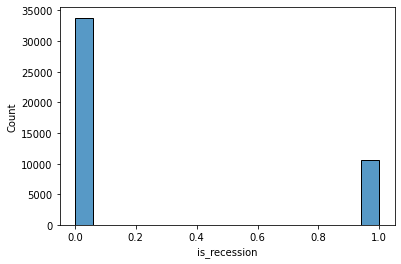

In [44]:
sns.histplot(df, x='is_recession');

## Money Supply, Inflation, and Employment Measures

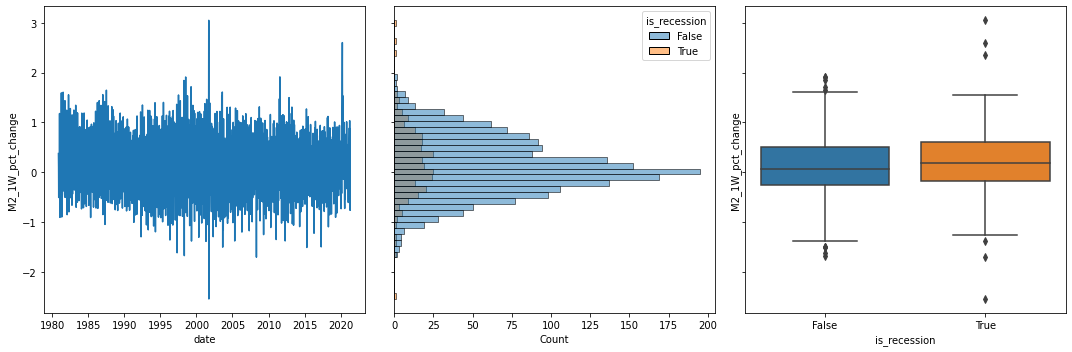

In [45]:
col = 'M2_1W_pct_change'

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.lineplot(data=df, x='date', y=col, ax=ax[0])
sns.histplot(data=df, y=col, hue='is_recession', ax=ax[1])
sns.boxplot(data=df, y=col, x='is_recession', ax=ax[2])
plt.tight_layout()

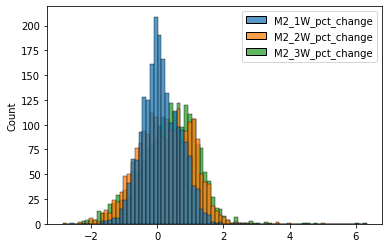

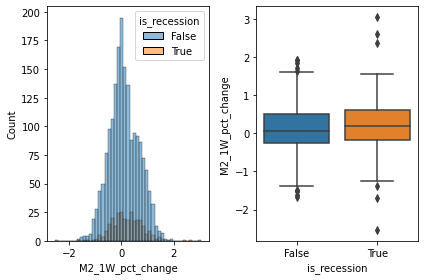

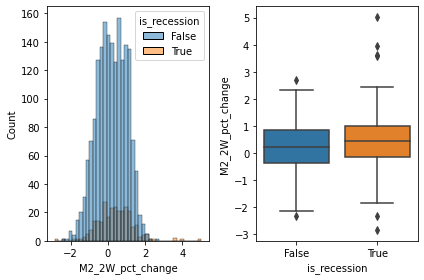

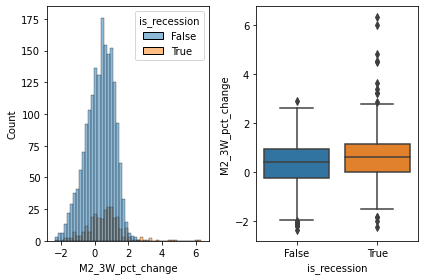

In [46]:
sns.histplot(df[['M2_1W_pct_change', 'M2_2W_pct_change', 'M2_3W_pct_change']]);

for col in ['M2_1W_pct_change', 
               'M2_2W_pct_change', 
               'M2_3W_pct_change']:
  fig, ax = plt.subplots(1, 2)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0]);
  sns.boxplot(data=df, x='is_recession', y =col, ax=ax[1])
  plt.tight_layout()

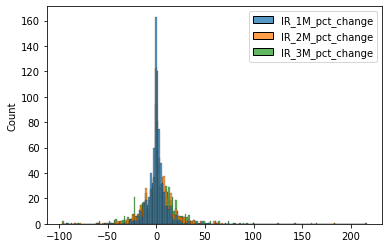

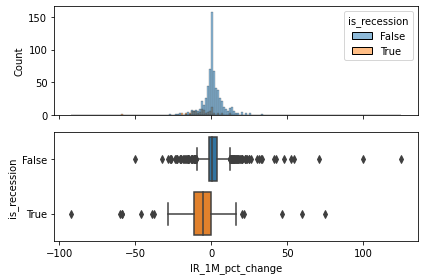

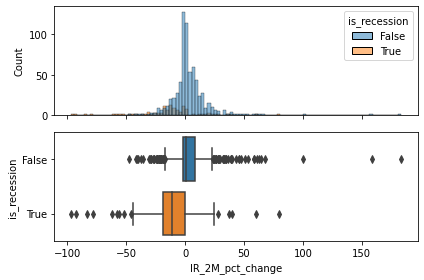

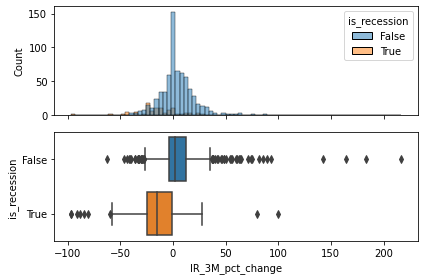

In [47]:
subset = ['IR_1M_pct_change', 'IR_2M_pct_change', 'IR_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

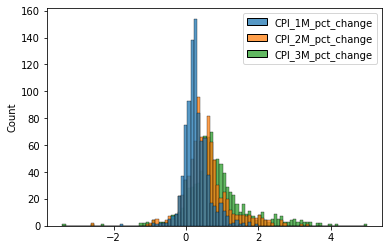

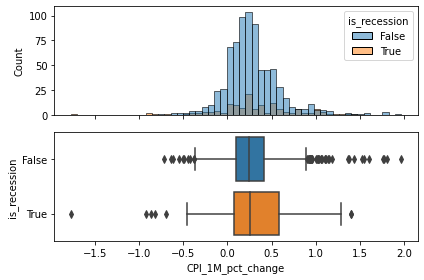

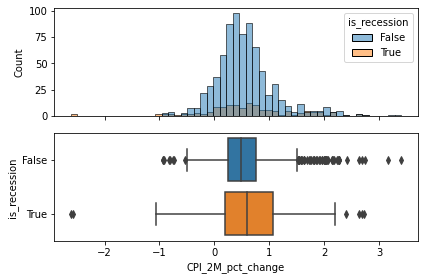

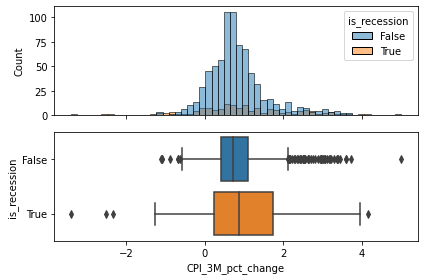

In [48]:
subset= ['CPI_1M_pct_change', 'CPI_2M_pct_change', 'CPI_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

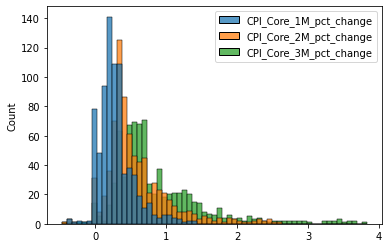

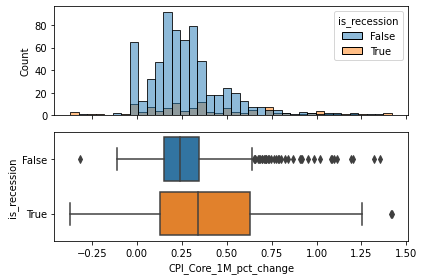

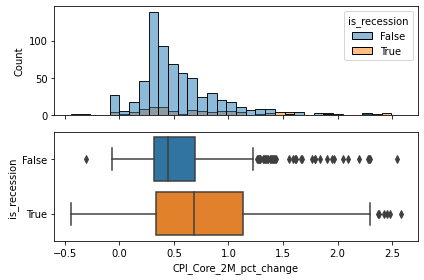

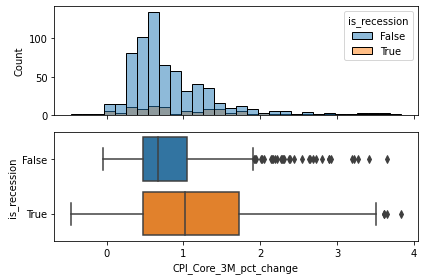

In [49]:
subset= ['CPI_Core_1M_pct_change', 'CPI_Core_2M_pct_change', 'CPI_Core_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

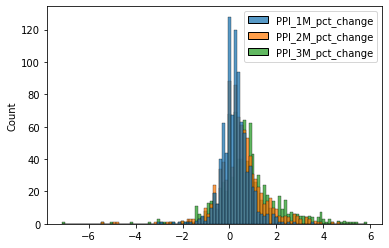

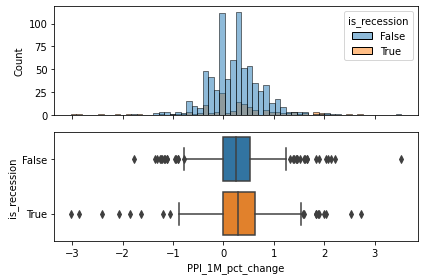

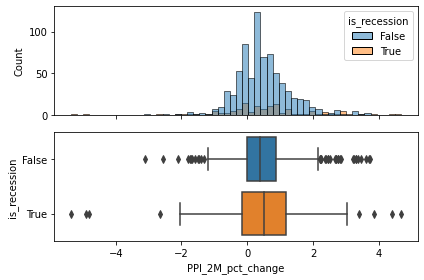

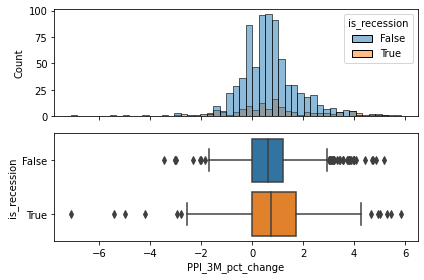

In [50]:
subset= ['PPI_1M_pct_change', 'PPI_2M_pct_change', 'PPI_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

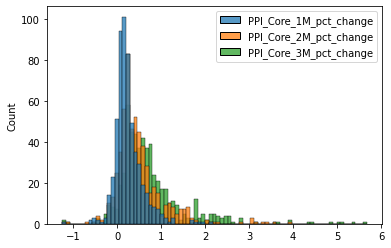

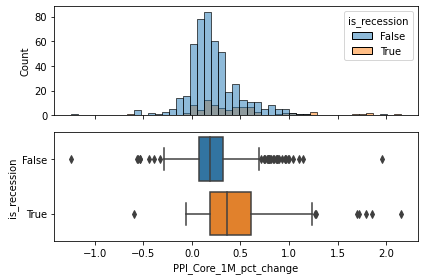

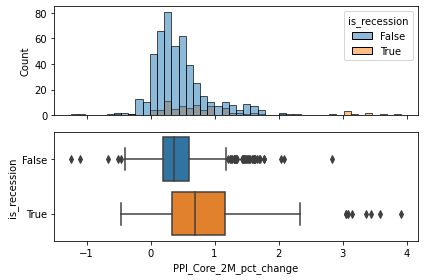

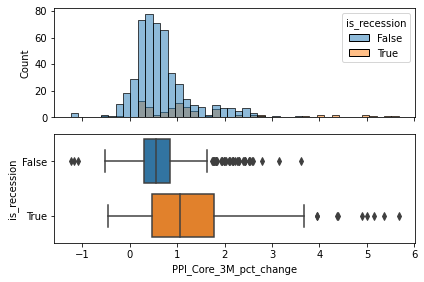

In [51]:
subset= ['PPI_Core_1M_pct_change', 'PPI_Core_2M_pct_change', 'PPI_Core_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

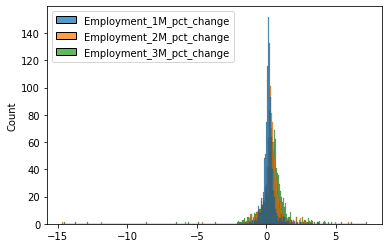

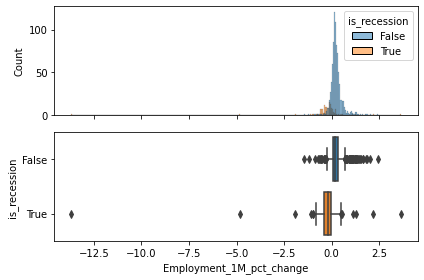

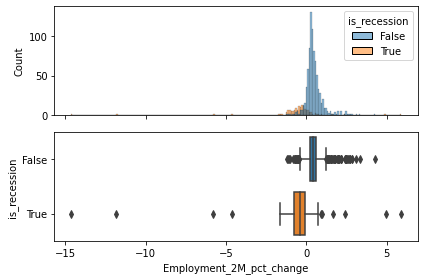

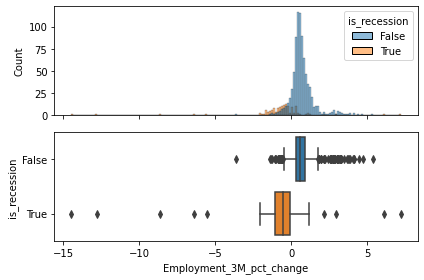

In [52]:
subset= ['Employment_1M_pct_change', 'Employment_2M_pct_change', 'Employment_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

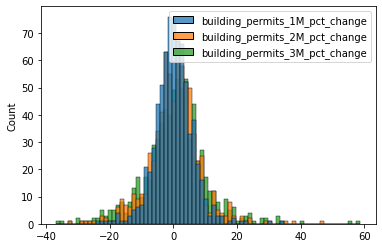

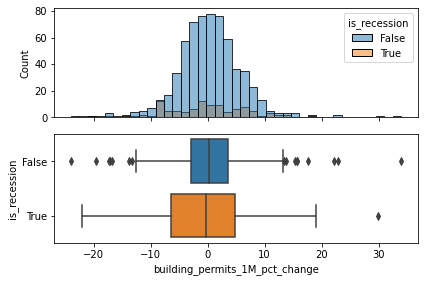

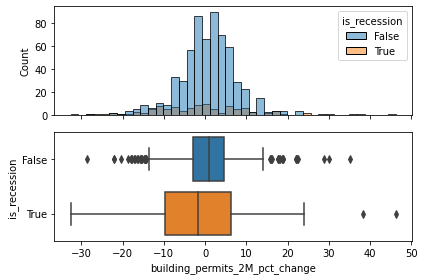

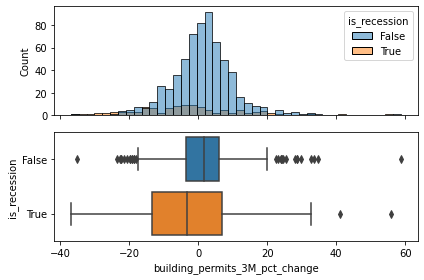

In [53]:
subset= ['building_permits_1M_pct_change', 'building_permits_2M_pct_change', 'building_permits_3M_pct_change']

sns.histplot(df[subset])

for col in df[subset].columns:
  fig, ax = plt.subplots(2, 1, sharex=True)
  sns.histplot(data=df, x=col, hue='is_recession', ax=ax[0])
  sns.boxplot(data=df, x=col, y='is_recession', ax=ax[1], orient='h')
  plt.tight_layout()

In [54]:
df.fillna(method='ffill')

,debt_as_pct_of_gdp,surplus_or_deficit_as_pct_of_gdp,interest_payments_as_pct_of_gdp,10_year_rates,gdp_growth,michigan_consumer_sentiment,M2_1W_pct_change,M2_2W_pct_change,M2_3W_pct_change,M2_4W_pct_change,M2_12W_pct_change,IR_1M_pct_change,IR_2M_pct_change,IR_3M_pct_change,CPI_1M_pct_change,CPI_2M_pct_change,CPI_3M_pct_change,CPI_Core_1M_pct_change,CPI_Core_2M_pct_change,CPI_Core_3M_pct_change,PPI_1M_pct_change,PPI_2M_pct_change,PPI_3M_pct_change,PPI_Core_1M_pct_change,PPI_Core_2M_pct_change,PPI_Core_3M_pct_change,Employment_1M_pct_change,Employment_2M_pct_change,Employment_3M_pct_change,building_permits_1M_pct_change,building_permits_2M_pct_change,building_permits_3M_pct_change,liquidity_cover_ratio,central_bank_total_assets_as_pct_of_gdp,is_recession,MAN_PMI_PMI,NONMAN_NMI_Index
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-22,129.09116,-4.6399,1.64643,1.64,11.0,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7
2021-05-23,129.09116,-4.6399,1.64643,1.64,11.0,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7
2021-05-24,129.09116,-4.6399,1.64643,1.64,11.0,84.9,0.577466,-0.190198,-0.163634,-0.585513,4.034308,0.0,-12.5,-22.222222,0.770035,1.394964,1.75456,0.916619,1.258236,1.360985,0.279981,1.559546,3.119002,0.609185,0.892857,1.082863,0.184668,0.7231,1.101334,-1.253561,0.405562,-7.966012,7.331581,35.913485,True,60.7,62.7


##Soverign Default Risk Measures

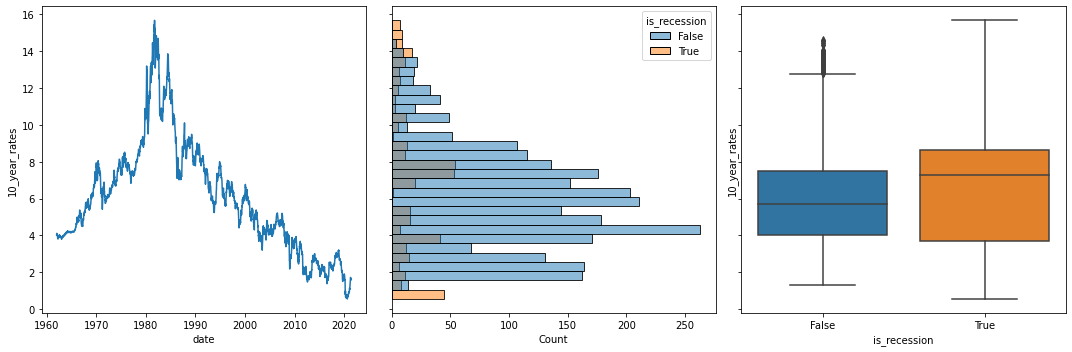

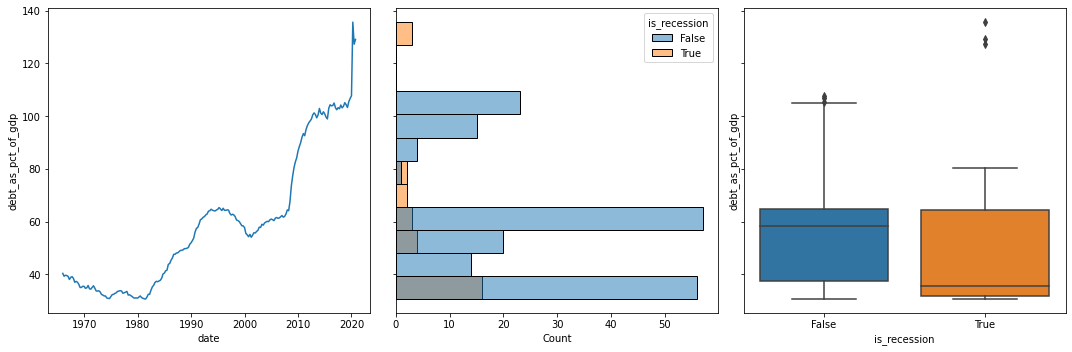

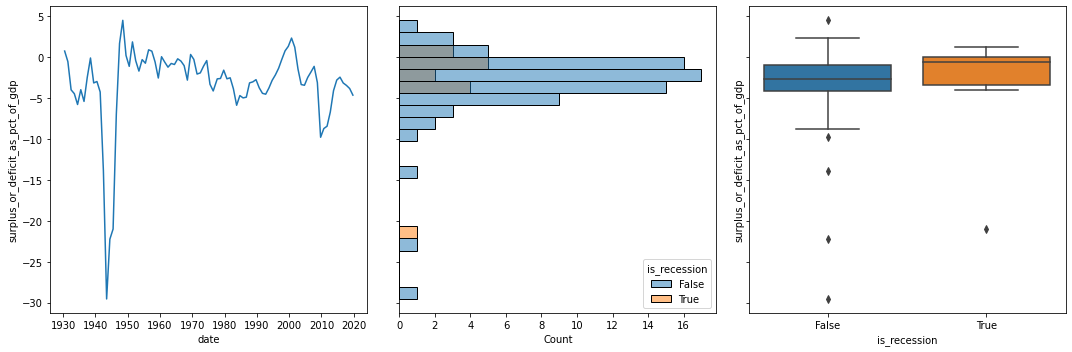

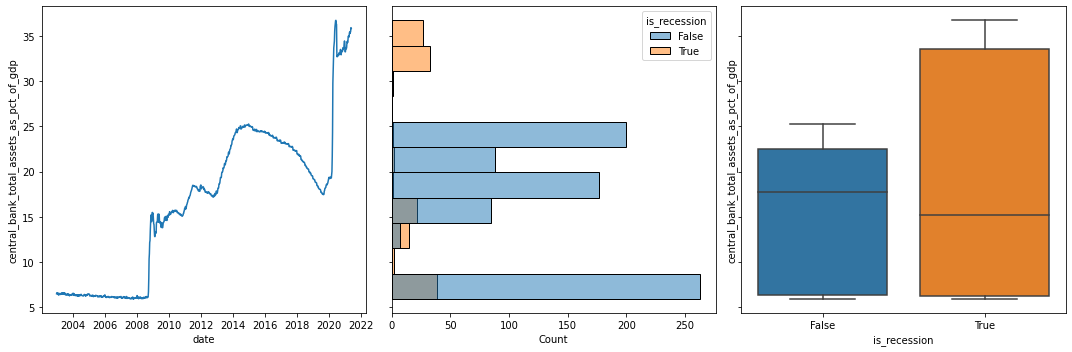

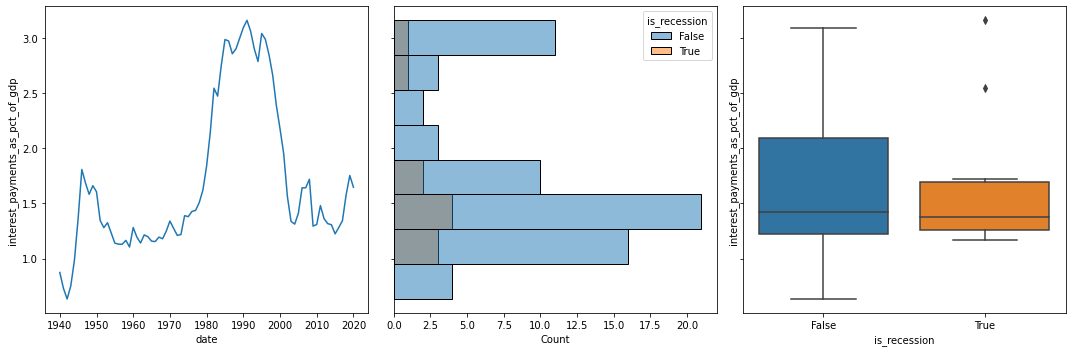

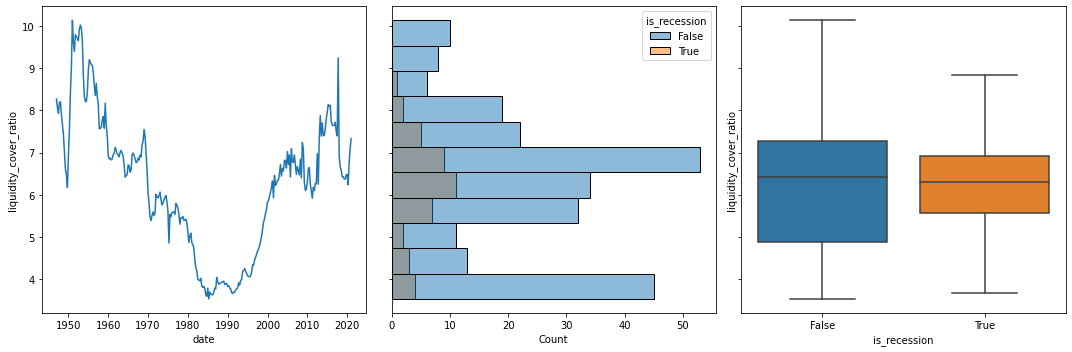

In [18]:
subset = [
        '10_year_rates',
        'debt_as_pct_of_gdp',
        'surplus_or_deficit_as_pct_of_gdp',
        'central_bank_total_assets_as_pct_of_gdp',
        'interest_payments_as_pct_of_gdp',
        'liquidity_cover_ratio',
        ]

for col in subset:
  fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
  sns.lineplot(data=df, x='date', y=col, ax=ax[0])
  sns.histplot(data=df, y=col, hue='is_recession', ax=ax[1])
  sns.boxplot(data=df, y=col, x='is_recession', ax=ax[2])
  plt.tight_layout()

## Business and Consumer Sentiment indicators

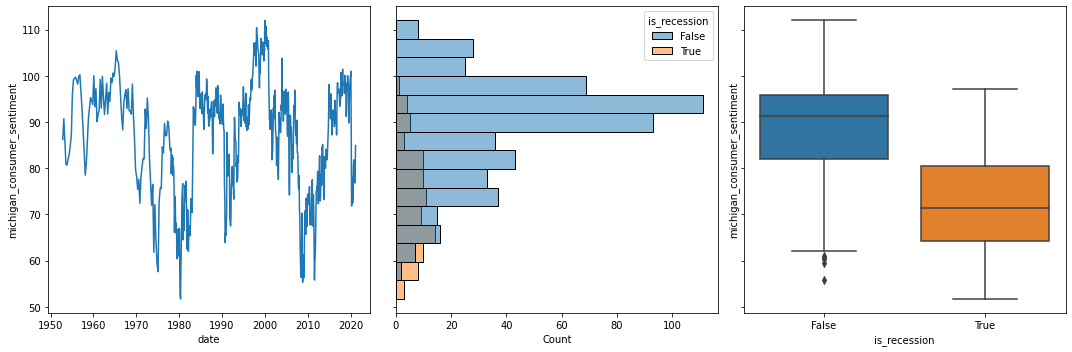

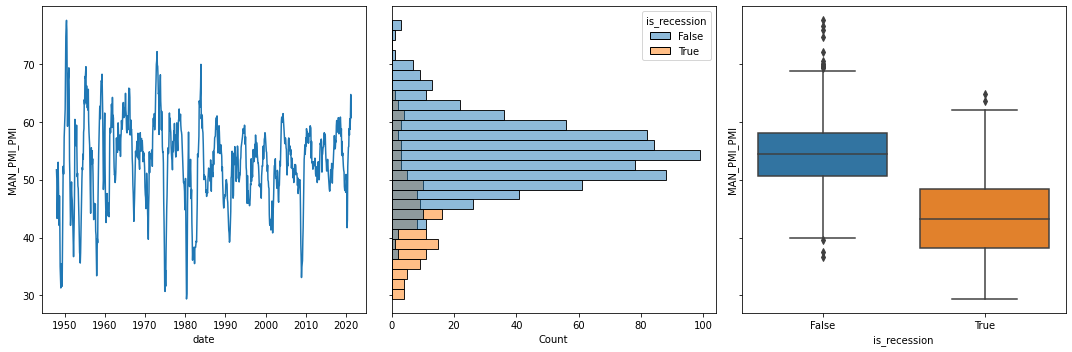

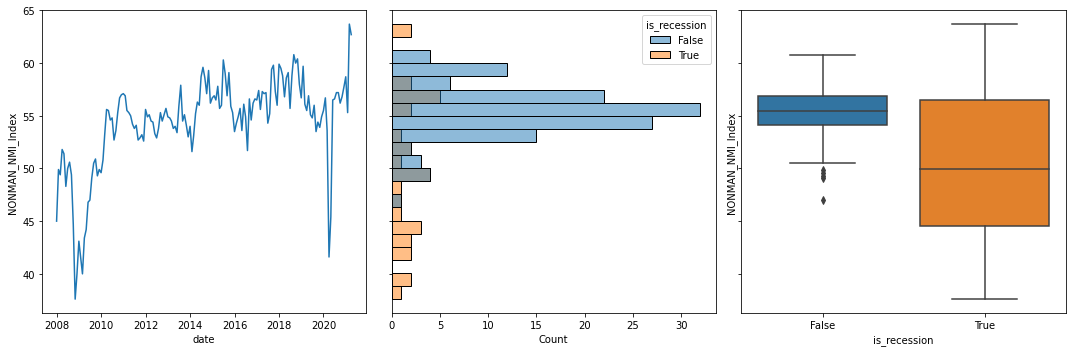

In [36]:
subset = [
          'michigan_consumer_sentiment', 
          'MAN_PMI_PMI', 
          'NONMAN_NMI_Index',
         ]

for col in subset:
  fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
  sns.lineplot(data=df, x='date', y=col, ax=ax[0])
  sns.histplot(data=df, y=col, hue='is_recession', ax=ax[1])
  sns.boxplot(data=df, y=col, x='is_recession', ax=ax[2])
  plt.tight_layout()

# Modelling

In [66]:
X = df.drop(columns=['gdp_growth', 'is_recession']).fillna(method='ffill').dropna()
y = df['gdp_growth']
Xy = X.join(y).dropna()
X = Xy.drop(columns=['gdp_growth'])
y = Xy['gdp_growth']

In [95]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(37, 35) (16, 35) (37,) (16,)


In [103]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f'r2_score: {r2_score(y_test, y_pred)}')
print(f'mean_absolute_error: {mean_absolute_error(y_test, y_pred)}')
                   

r2_score: 0.3767739304681106
mean_absolute_error: 5.062499999999999


In [104]:
from sklearn.linear_model import LinearRegression

# Needs scaling
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f'r2_score: {r2_score(y_test, y_pred)}')
print(f'mean_absolute_error: {mean_absolute_error(y_test, y_pred)}')
                   

r2_score: -13.26012466710979
mean_absolute_error: 40.599714896662455


In [ ]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from hcrystalball.model_selection import ModelSelector

ms = ModelSelector(horizon=1,
                   frequency='Q'
                  )

ms.create_gridsearch(sklearn_models=True,
                    n_splits = 10,
                    # between_split_lag=0,
                    sklearn_models_optimize_for_horizon=False,
                    autosarimax_models=False,
                    prophet_models=True,
                    tbats_models=True,
                    exp_smooth_models=True,
                    average_ensembles=False,
                    stacking_ensembles=False,
                    exog_cols=list(X.select_dtypes(include=np.number).columns),
#                     holidays_days_before=2,
#                     holidays_days_after=1,
#                     holidays_bridge_days=True,
                    )

#SkLearn models
from hcrystalball.wrappers import get_sklearn_wrapper

# Most sklearn models benefit from scaling of numeric features
sklearn_native_transformers = TSColumnTransformer(
    transformers=[
        ('scaler', 
          StandardScaler(), 
          list(X.select_dtypes(include=np.number).columns)
        )
        ])

# Decision Tree 
from sklearn.tree import DecisionTreeRegressor
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(DecisionTreeRegressor, name='dt'))
            ]))

# Random Forest
from sklearn.ensemble import RandomForestRegressor
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(RandomForestRegressor, name='rf'))
            ]))

# Linear Regression
from sklearn.linear_model import LinearRegression
ms.add_model_to_gridsearch(
    Pipeline([
            ('sklearns_native_transformers', sklearn_native_transformers),
            ('model', get_sklearn_wrapper(LinearRegression, name='lr'))
            ]))



# from hcrystalball.wrappers import SarimaxWrapper
# ms.add_model_to_gridsearch(SarimaxWrapper(init_with_autoarima=True))

from hcrystalball.wrappers import ProphetWrapper
ms.add_model_to_gridsearch(ProphetWrapper())

from hcrystalball.wrappers import ExponentialSmoothingWrapper
ms.add_model_to_gridsearch(ExponentialSmoothingWrapper())

from hcrystalball.wrappers import TBATSWrapper
ms.add_model_to_gridsearch(TBATSWrapper())

# from hcrystalball.wrappers import SimpleSmoothingWrapper
# from hcrystalball.wrappers import HoltSmoothingWrapper
# from hcrystalball.wrappers import BATSWrapper

ms.select_model(df=Xy,
                target_col_name='gdp_growth',
                # persist_model_selector_results=False,
                # output_path='my_results',
               )

Select Models:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ms.plot_results(plot_from='2010', figsize=(15,15));

In [ ]:
ms.results[0]

In [ ]:
ms.results[0].best_model_cv_results